#### Inspired by the work of:

https://medium.com/@tuennermann/convolutional-neural-networks-to-find-cars-43cbc4fb713

https://github.com/HTuennermann/Vehicle-Detection-and-Tracking

https://github.com/heuritech/convnets-keras

https://github.com/maxritter/SDC-Vehicle-Lane-Detection


#### 1. Config

In [15]:
# Visualisation parameters
display_output = 1
train_verbose_style = 2  # 1 every training image, 2 once very epoch

# Training parameters
use_generator = 0
epoch_num = 20
train_model = 0

#### 2. Project 5 data set import

In [10]:
import glob
import numpy as np
from sklearn.model_selection import train_test_split

cars = glob.glob("./dataset/vehicles/*/*.png")
non_cars = glob.glob("./dataset/non-vehicles/*/*.png")

# feature list
X = []

# Append cars and non-cars image file paths to the feature list
for car in cars:
    X.append(car)

for non_car in non_cars:
    X.append(non_car)
    
X = np.array(X)

# Generate Y Vector (Cars = 1, Non-Cars = -1)
y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])

# Randomly split the file paths in a validation set and a training set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

print("Loading done!")

Loading done!


#### 3. Print a dataset summary

In [11]:
import matplotlib.image as mpimg

# if Display output is activated, configure matplotlib to show figure inside the notebook
if display_output == 1:
    %matplotlib inline

# Load the 1rst image to get its size
train_img = mpimg.imread(X_train[0])

# Dataset image shape
image_shape = train_img.shape

# Number of unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", X_train.shape[0])
print("Number of validation examples =", X_valid.shape[0])
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 15984
Number of validation examples = 1776
Image data shape = (64, 64, 3)
Number of classes = 2


#### 4. Exploratory visualization of the dataset

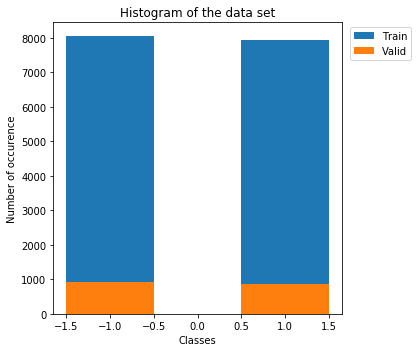

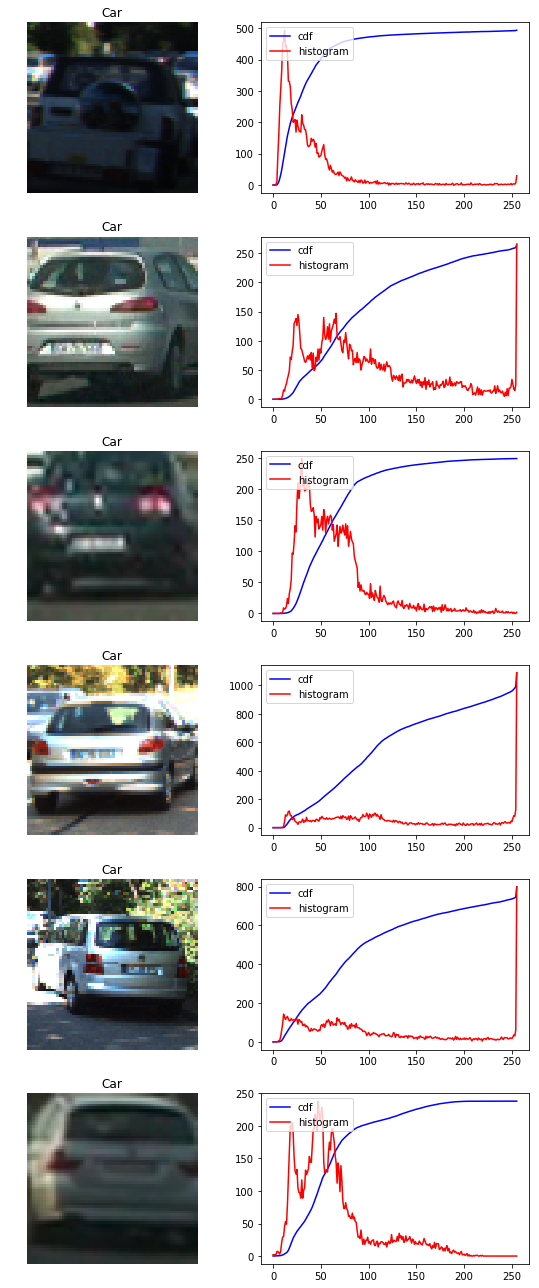

In [12]:
from util import show_sample
from util import show_training_dataset_histogram
display_output = 0

show_training_dataset_histogram(y_train, y_valid, display=display_output)
show_sample(X_train, y_train, sample_num=6, sample_index=100, display=display_output)

#### 5. Show a sample of preprocessed data

In [5]:
show_sample(X_train, y_train, preprocess=1, sample_num=6, sample_index=100, display=display_output)    

#### 6. Get Model

In [43]:
from model import get_model
from keras.layers import Flatten

# Get the "base" ConvNet Model
model = get_model()

# Flat out the last layer for training
model.add(Flatten())

# Print out model summary
if display_output == 1:
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
__________

#### 7. Declare generators/load dataset

In [13]:
from util import keras_generator
from util import generator

# Prepare generator functions /dataset
if use_generator == 1:
    # Use the generator function
    train_generator =      keras_generator(X_train, y_train, batch_size=32)
    validation_generator = keras_generator(X_valid, y_valid, batch_size=32)
else:
    # Load all the preprocessed images in memory
    train_set =      generator(X_train, y_train)
    validation_set = generator(X_valid, y_valid)

#### 8. Train Model and save the best weights

In [8]:
from keras.callbacks import ModelCheckpoint
from util import plot_train_results
from util import keras_generator
from keras.optimizers import Adam

if train_model == 1:
    # Compile the model
    model.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])

    # saves the model weights after each epoch if the validation loss decreased
    filepath = './weights/best-weights.hdf5'
    checkpointer = ModelCheckpoint(filepath=filepath,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='min')

    # Train the model, with or without a generator
    if use_generator == 1:
        history_object = model.fit_generator(train_generator,
                                             steps_per_epoch=len(X_train),
                                             epochs=epoch_num,
                                             verbose=train_verbose_style,
                                             callbacks=[checkpointer],
                                             validation_data=validation_generator,
                                             validation_steps=len(X_valid))

    else:
        history_object = model.fit(train_set[0],
                                   train_set[1],
                                   batch_size=128,
                                   epochs=epoch_num,
                                   verbose=train_verbose_style,
                                   callbacks=[checkpointer],
                                   validation_data=(validation_set[0], validation_set[1]))

    plot_train_results(history_object, display_output)

## Testing the classifier

#### Load weights

In [4]:
# Load the weight
model.load_weights('./weights/best-weights.hdf5')
print("Weights loaded!")

Weights loaded!


#### Test the classifier on random images

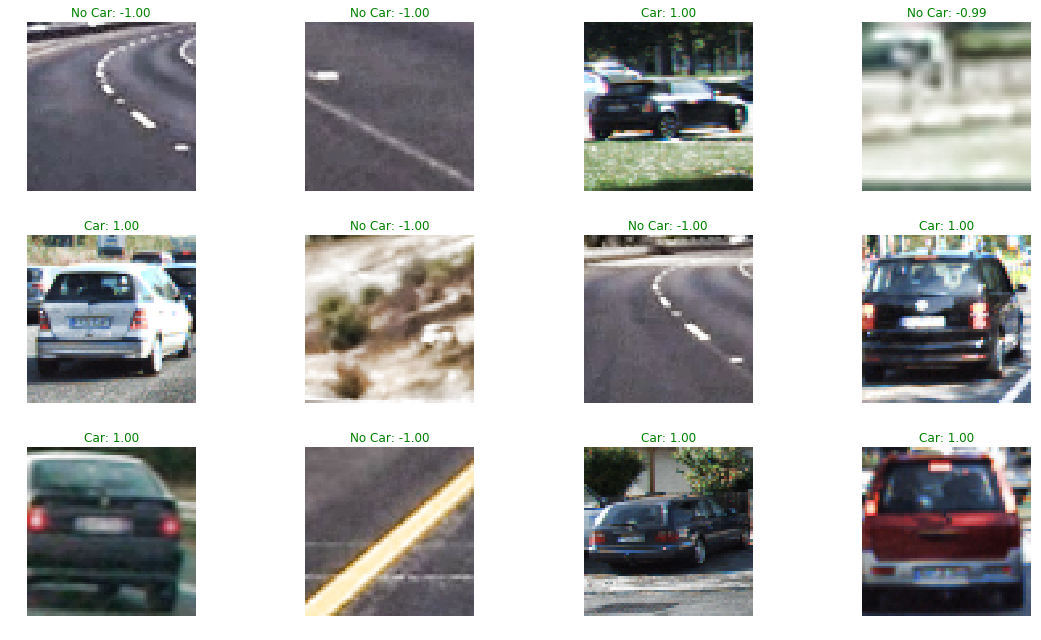

In [42]:
if display_output == 1:

    import matplotlib.pyplot as plt
    %matplotlib inline
    
    sample_num = 12
    
    col_num = 4
    row_num = int(sample_num/col_num)
    
    # Create training sample + histogram plot
    f, axarr = plt.subplots(row_num, col_num, figsize=(col_num * 4, row_num * 3))
    
    for i in range(sample_num):
        
        # Pick a random image from the validation set
        index = np.random.randint(validation_set[0].shape[0])

        # Add one dimension to the image to fit the CNN input shape...
        sample = np.reshape(validation_set[0][index], (1, 64,64,3))

        # Infer the label
        inference = model.predict(sample, batch_size=64, verbose=0)

        # Extract inference value
        inference = inference[0][0]

        # Show the image
        color_str = 'green'
        if inference >= 0.0:
            title_str = "Car: {:4.2f}" .format(inference)
            if validation_set[1][index] != 1:
                color_str = 'red'            
        else:
            title_str = "No Car: {:4.2f}" .format(inference)
            
            if validation_set[1][index] != -1:
                color_str = 'red'
       
        axarr[int(i/col_num), i % col_num].imshow(validation_set[0][index])
        axarr[int(i/col_num), i % col_num].set_title(title_str, color = color_str)
        axarr[int(i/col_num), i % col_num].axis('off')
        
    f.tight_layout()
    plt.show()